## Import required libraries.

In [1]:
%%capture
import operator
import seaborn as sns; sns.set()
from jupyterthemes import jtplot
jtplot.style()
import numpy as np
from landlab import FieldError
from landlab.utils import get_watershed_mask
import xarray as xr
import pandas as pd
import scipy
import gdal
from scipy import ndimage
from scipy.ndimage.filters import *
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.signal import medfilt
import os
import math
from osgeo import osr
from fractions import Fraction
import timeit
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
%matplotlib inline
import random
# import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl
from landlab.plot.imshow import imshow_grid 

# import necessary landlab components
from landlab import RasterModelGrid, HexModelGrid
from landlab.components import FlowAccumulator, LakeMapperBarnes, SinkFillerBarnes
from landlab.components import(FlowDirectorD8, 
                               FlowDirectorDINF, 
                               FlowDirectorMFD, 
                               FlowDirectorSteepest)
from landlab.components import DepressionFinderAndRouter
# import landlab plotting functionality
from landlab.plot.drainage_plot import drainage_plot
from pylab import show, figure

# create a plotting routine to make a 3d plot of our surface. 
def surf_plot(mg, surface='topographic__elevation', 
              title='Surface plot of topography', colormap = cm.gray):
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Plot the surface.
    Z = (mg.at_node[surface].reshape(mg.shape))#[y1:y2, x1:x2]
    color = colormap((Z-Z.min())/(Z.max()-Z.min()))
    surf = ax.plot_surface(mg.node_x.reshape(mg.shape),#[y1:y2, x1:x2]
                           mg.node_y.reshape(mg.shape),#[y1:y2, x1:x2]
                           Z,
                           rstride=1, cstride=1,
                           facecolors=color,
                           linewidth=0.,
                           antialiased=False)
    ax.view_init(elev=35, azim=-120) 
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Elevation')
    plt.title(title)
    plt.show()

## Setup input data 
Define spatial resolution: Specify the resolution of the input DEM and also the desired working resolution (can be same as input DEM resolution).

In [3]:
def roundup(x):
    return int(math.ceil(x / 10.0)) * 10

input_DEM_resolution = 1
working_resolution = 1
location = (r'C:\PhD\manuscript\automated_topographic_thresholds\data')
os.chdir(location)
input_geotiff = gdal.Open('fitz_s_32.tif')
x = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())
empty_grid_rows = roundup(x.shape[0])
empty_grid_cols = roundup(x.shape[1])
input_DEM = np.zeros([empty_grid_rows,empty_grid_cols])
input_DEM[:x.shape[0], :x.shape[1]] = x

input_outlets = gdal.Open('fitz_dsna.tif')
o = np.array(input_outlets.GetRasterBand(1).ReadAsArray())
outlets= o
#outlets = 1 - o

In [4]:
step_s = 3
comp_d = 3

## Visualise the DEM.

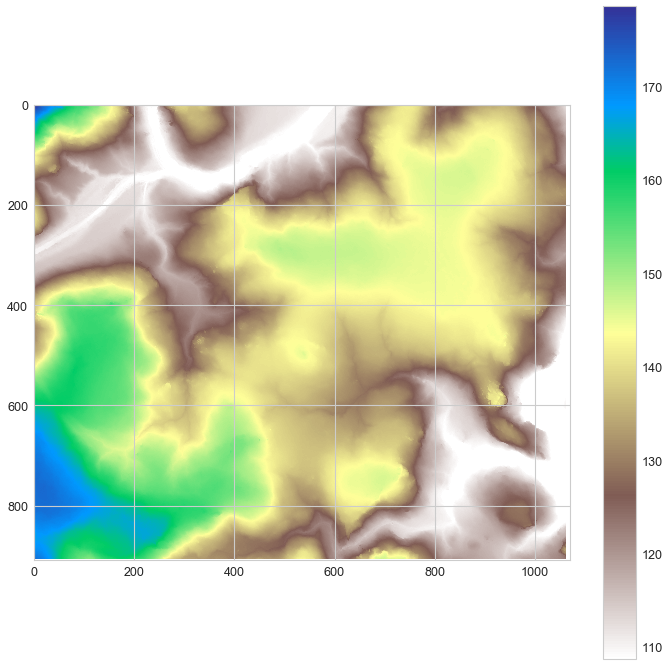

In [5]:
plt.figure(figsize=(12,12))
plt.imshow(input_DEM, cmap="terrain_r", vmin = np.percentile(input_DEM, 5));
plt.colorbar();

## Define required function.

In [6]:
def rectangleWindow(m, n):
    """Takes a value for number of rows (m) and number of columns (n) such that
       m and n are both positive real numbers and creates a rectangle of 
       boolian 'True' values."""
    rectangle = np.ones((m, n), dtype=bool) 
    return rectangle
def number_of_values(Window):
    """This funciton takes the shape function as an input and returns a number 
        of values present in the specified shape. 
        
        This can be different for a different window shape and to initialize
        requires the specification of the function for the given window type and 
        parameter values required for that input function.
        
        To initialize this function for shape == rectangle type 'number_of_values(rectangleWindow(m,n)) 
        where m and n are any positive real number as per the rectangleWindow function."""
    denominator = sum(sum(Window > 0))
    return denominator
def circleWindow(radius):
    """Takes a value for radius (r where r is any positive real number) and creates 
       a circular window using that radius."""
    y, x = np.ogrid[-radius: radius + 1, -radius: radius + 1]
    circle = x**2 + y**2 <= radius**2
    return circle
def find_median_value(Window):
    """This function takes the shape function and returns the median value 
        for all valid values (values that fall in the circle) arranged into a 
        1d array. The function also takes the number_of_values function as an input.
        To execute this function type 'find_median_value(shape(r)) where r is any integer.
        #Note: using median like this only gives the correct value for circles with odd 
        radius values."""
    no_values = number_of_values(Window)
    value_range = np.arange(0, no_values + 1)
    central_value = int(np.median(value_range))
    return central_value
def differenceFromMeanElevation(elev):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = elev[central_value]                        
    mean = np.nanmean(elev)#Count number of values greater than centroid value
    diff = centroid - mean
    return diff
def PCTL(x):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = x[central_value]                        
    y = np.sum(x < centroid)/num_values#Count number of values greater than centroid value
    return y
def flow_dir_dataset(flow_rec_prop, catchment_area, grid_resolution, outlet_node):
    """ Create an xarray Dataset containing eight arrays each representing the
    amount of water flowing in the given direction.
        1 . flow_rec_prop == the flow receiver proportion array created by LandLab flow routing.
        2 . catchment_area == the corresponding catchment area array from the landLab flow accumulation.
        surface.        
    The resulting Dataset is used to calculate specific catchment area."""
    array_direction = xr.Dataset()
    for i in range(0,8):
        rows = catchment_area.shape[0]; cols = catchment_area.shape[1];
        direction = np.flip(flow_rec_prop[:,i].reshape(rows,cols), 0);
        # Above needs to be flipped because during reshape it organises data top down
        # rather than bottom up as per ModelGrid order (catchment_area is mg arrangement).
        zero_outlet = outlet_node != 1
        remove_outlet = zero_outlet * catchment_area
        weighted_direction = xr.DataArray((remove_outlet * direction),
                                          dims = ['lat', 'lon']);
        array_direction[direction_list[i]] = weighted_direction
        
    E, N, W, S, NE, NW, SW, SE = (array_direction['East'], array_direction['North'],
                             array_direction['West'], array_direction['South'],
                             array_direction['North East'], array_direction['North West'],
                             array_direction['South West'], array_direction['South East'])

    flow_dirs = xr.concat([E, N, W, S, NE, NW, SW, SE], 'direction')
    flow_dirs.name = 'flow_directions'
    flow_dirs.attrs['grid cell resolution'] = grid_resolution
    flow_directions = flow_dirs.assign_coords(direction=(['East','North','West','South',
                                   'North East', 'North West','South West', 'South East']))
    return flow_directions
def profileCurvature(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
       systems, Page 284)."""
    Z1 = DEM[0]; Z2 = DEM[1]; Z3 = DEM[2]
    Z4 = DEM[3]; Z0 = DEM[4]; Z5 = DEM[5]
    Z6 = DEM[6]; Z7 = DEM[7]; Z8 = DEM[8]
    D = (((Z4 + Z5)/2) - Z0) / cellsize**2
    E = (((Z2 + Z7)/2) - Z0) / cellsize**2
    F = (Z3 - Z1 + Z6 - Z8)/ (4 * cellsize**2)
    G = (Z5 - Z4) / (2 * cellsize)
    H = (Z2 - Z7) / (2 * cellsize)
    profile_curvature = (-2 * (D*(G**2) + E*(H**2) + (F*G*H))) / (G**2 + H**2)
    return profile_curvature
def slopeWindowDegrees(DEM, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM[0]; b = DEM[1]; c = DEM[2]
    d = DEM[3]; e = DEM[4]; f = DEM[5]
    g = DEM[6]; h = DEM[7]; i = DEM[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_percent = rise_run * 100
    #Can also ask it to return slope_degrees but asking for both causes it to throw and error.
    return slope_degrees
def closest(lst, K): 
     angle_list = lst
     idx = (np.abs(angle_list - K)).argmin() 
     return angle_list[idx]  
def data_range(data):
    data_min = np.amin(data); data_max = np.amax(data)
    value_range = data_max - data_min
    return value_range
def checkGullyHead(dfme_list, step_size, comparison_distance, minimum_depth, elevation_of_gh):
    
    """ """
    max_value_length = len(dfme_list) - step_size - comparison_distance - step_size
    for i in range(0, max_value_length):
                
        start_of_downstream_nodes = i
        end_of_downstream_nodes = i + step_size       
        downstream_nodes = dfme_list[start_of_downstream_nodes:end_of_downstream_nodes]
        
        start_of_upstream_nodes = i + step_size + comparison_distance
        end_of_usptreat_nodes = start_of_upstream_nodes + step_size
        upstream_nodes = dfme_list[start_of_upstream_nodes:end_of_usptreat_nodes]
        
        min_downstream = np.min(downstream_nodes)
        mean_upstream = np.mean(upstream_nodes)
        std_upstream = np.std(upstream_nodes)
        elevation_difference = min_downstream - mean_upstream
        print('minimum downstream value: ', min_downstream)
        print('mean upstream value: ', mean_upstream)
        print('std upstream value: ', std_upstream)
      
        if min_downstream <= minimum_depth and mean_upstream > elevation_of_gh and std_upstream < 0.1 and elevation_difference <= -0.2:
            keep_gully = 'yes'
            # below could use either floor or ceil instead of round 
            gully_head_location = int(end_of_downstream_nodes + np.round(comparison_distance/2))
            break
        else:
            keep_gully = 'no'
            gully_head_location = 'none'

    return keep_gully, gully_head_location
def checkGullyEdges(dfme_list, step_size, comparison_distance, minimum_depth, elevation_of_gh):
    
    """ """
    max_value_length = len(dfme_list) - step_size - comparison_distance - step_size
    for i in range(0, max_value_length):
                
        start_of_downstream_nodes = i
        end_of_downstream_nodes = i + step_size       
        downstream_nodes = dfme_list[start_of_downstream_nodes:end_of_downstream_nodes]
        
        start_of_upstream_nodes = i + step_size + comparison_distance
        end_of_usptream_nodes = start_of_upstream_nodes + step_size
        upstream_nodes = dfme_list[start_of_upstream_nodes:end_of_usptream_nodes]
        
        min_downstream = np.min(downstream_nodes)
        mean_upstream = np.mean(upstream_nodes)
        std_upstream = np.std(upstream_nodes)
        elevation_difference = min_downstream - mean_upstream
        #print('minimum downstream value: ', min_downstream)
        #print('mean upstream value: ', mean_upstream)
        #print('std upstream value: ', std_upstream)
      
        if min_downstream <= minimum_depth and mean_upstream > elevation_of_gh and std_upstream < 0.1 and elevation_difference <= -0.2:
            keep_gully = 'yes'
            # below could use either floor or ceil instead of round 
            gully_head_location = int(start_of_upstream_nodes)
            break
        else:
            keep_gully = 'no'
            gully_head_location = 'none'

    return keep_gully, gully_head_location
def checkGullyEdgesElev(dfme_list, elev_list,step_size, comparison_distance, minimum_depth, elevation_of_gh, height_change):
    
    """ """
    max_value_length = len(dfme_list) - step_size - comparison_distance - step_size

    for i in range(0, max_value_length):
                
        start_of_downstream_nodes = i
        end_of_downstream_nodes = i + step_size       
        downstream_nodes = dfme_list[start_of_downstream_nodes:end_of_downstream_nodes]
        
        start_of_upstream_nodes = i + step_size + comparison_distance
        end_of_usptream_nodes = start_of_upstream_nodes + step_size
        upstream_nodes = dfme_list[start_of_upstream_nodes:end_of_usptream_nodes]
        
        min_downstream = np.min(downstream_nodes)
        mean_upstream = np.mean(upstream_nodes)
        #std_upstream = np.std(upstream_nodes)
        std_upstream = np.std(elev_list[start_of_upstream_nodes:end_of_usptream_nodes])
        
        elevation_difference = np.mean(elev_list[start_of_upstream_nodes:end_of_usptream_nodes])-np.min(elev_list[start_of_downstream_nodes:end_of_downstream_nodes])
        print('upstream mean: ', np.mean(elev_list[start_of_upstream_nodes:end_of_usptream_nodes]))
        print('downstream min: ', np.min(elev_list[start_of_downstream_nodes:end_of_downstream_nodes]))
        print('elevation difference: ', elevation_difference)
        #print('minimum downstream value: ', min_downstream)
        #print('mean upstream value: ', mean_upstream)
        #print('std upstream value: ', std_upstream)
      
        if min_downstream <= minimum_depth and mean_upstream > elevation_of_gh and std_upstream < 0.1 and elevation_difference >= height_change:
            keep_gully = 'yes'
            # below could use either floor or ceil instead of round 
            gully_head_location = int(start_of_upstream_nodes)
            break
        else:
            keep_gully = 'no'
            gully_head_location = 'none'

    return keep_gully, gully_head_location
def upstreamDrainageLine(meters_from_gully_head, input_DEM_resolution, grid_nodes, DEM, import_drainage_area, 
                         import_dfme, catchment_outlet_ids, step_size_m, comparison_distance_m,  
                         slope_above_head, min_depth, gh_elevation):
    
    """This function works its way up the hillslope from a gully head recording 
    catchment area at each grid cell along the way. Then for each gully head it assesses whether divergence is occuring 
    at any point by using the upslopeDivergence function.
    
    meters_from_gully_head == distance upstream from gully head in meters.
    input_DEM_resolution == grid resolution of the input DEM.
    frn == flow receiver nodes stored on the model grid object.
    catchment_outlet_ids == a list of grid cells found using the estimateCatchmentArea function.
    drainage_area == drainage area stored on the model grid object.
    grid_nodes == grid node values stored on the model grid object.
    DEM == initial input_DEM
    step_size_m and comparison_distance_m are both enetered in meters and are then adjusted automatically
    to fit the resolution.
    slope_above_head == the distance from the convergence point that slope is taken."""
    
    final_gully_head_position_dict = {}
    catchment_area_node_list = []
    distance_from_node = int(meters_from_gully_head / input_DEM_resolution)
    is_gully_head = {}
    slope_dict = {}
    slope_at_head = {}
    
    step_size = int(np.round(step_size_m / input_DEM_resolution))
    comparison_distance = int(np.round(comparison_distance_m / input_DEM_resolution))
    gully_head_node_dict = {}
    for i in catchment_outlet_ids:
        
        result = np.where(grid_nodes == i)
        #################################################################################################
        # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
        row_index = result[0][0];
        col_index = result[1][0];
        #################################################################################################
        # Create a subset based on above. Plus 1 to bottom abnd right so that the currenmmt gully ead node is always the 
        # centraL grid node of the subset.
        subset_row_top = int(row_index - distance_from_node)
        subset_row_bot = int(row_index + distance_from_node) + 1
        subset_col_left = int(col_index - distance_from_node)
        subset_col_right = int(col_index + distance_from_node) + 1
        #################################################################################################
        # Restrict the size of the subset in cases where it is on the edge of a DEM.
        subset_row_top_adjusted = max(subset_row_top, 0);
        subset_row_bot_adjusted = min(subset_row_bot, DEM.shape[0]);
        subset_col_left_adjusted = max(subset_col_left, 0);
        subset_col_right_adjusted = min(subset_col_right, DEM.shape[1]);
        #################################################################################################
        # Find the offset required by restricting the size of the subset around DEM edges.
        # This offset is needed to find the new location of the current gully head grid cell (no longer center of the subset).
        offset_row_top = int(np.sqrt((subset_row_top - subset_row_top_adjusted)**2)) * -1;
        offset_row_bot = int(np.sqrt((subset_row_bot - subset_row_bot_adjusted)**2));
        offset_col_left = int(np.sqrt((subset_col_left - subset_col_left_adjusted)**2)) * -1;
        offset_col_right = int(np.sqrt((subset_col_right - subset_col_right_adjusted)**2));
        #################################################################################################
        # Create subset around the current gully head grid node. 
        dem_subset_copy = np.copy(DEM);
        dem_subset = dem_subset_copy[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]
        
        #################################################################################################
        # Find the latitude and longitude index positions of the gully head node in the subset DEM.
        node_lat = distance_from_node + offset_row_top
        node_lon = distance_from_node + offset_col_left
        #################################################################################################  
        # Run M8 for the subset DEM.
        flow_acc_surf_sub = np.copy(dem_subset).astype('float64');
        rows_sub = flow_acc_surf_sub.shape[0];
        cols_sub = flow_acc_surf_sub.shape[1];
        mg1 = RasterModelGrid((rows_sub,cols_sub), 1);
        z1 = mg1.add_field('topographic__elevation', flow_acc_surf_sub, at = 'node');

        sfb = SinkFillerBarnes(mg1, method = 'Steepest', ignore_overfill = True);
        sfb.run_one_step();
        fa = FlowAccumulator(mg1,
                            surface = 'topographic__elevation',
                            flow_director = 'FlowDirectorMFD',
                            diagonals = True);

        fa.run_one_step()
        fd = FlowDirectorMFD(mg1, 'topographic__elevation', diagonals = True);
        fd.run_one_step()
        #################################################################################################
        # Extract required grid properties
        da = np.array(mg1.at_node['drainage_area'].round(4)); # Drainage area.
        
        #da_subset_copy = np.copy(import_drainage_area)
        import_da_subset = import_drainage_area[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]

        flattened_import_da = import_da_subset.reshape(da.shape)
        
        #dfme_subset_copy = np.copy(import_dfme)
        import_dfme_subset = import_dfme[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]
        flattened_import_dfme = import_dfme_subset.reshape(da.shape)
        
        grid_nodes_subset = grid_nodes[subset_row_top_adjusted:subset_row_bot_adjusted, 
                             subset_col_left_adjusted:subset_col_right_adjusted]
        
        flattened_grid_nodes_subset = grid_nodes_subset.reshape(da.shape)
        
        frn = mg1.at_node['flow__receiver_node'];# Flow receiver nodes.

        frp = np.array(mg1.at_node['flow__receiver_proportions']);# Flow receiver proportions
        flow_rec_surf_rows = cols_sub * rows_sub;
        flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);
        all_receiver_proportions = np.copy(frp);
        grid_nodes_sub = np.array(mg1.nodes.reshape(mg1.shape));
        #################################################################################################
        central_node = grid_nodes_sub[node_lat, node_lon]
        print(central_node)
        print(mg1.shape)
        # Specific the size of the area to be checked. This represents a physical distance from the 
        # outlet but has no unit of measure. Its maximum size is the size of the 'distance_from_node' variable.
        slope = generic_filter(dem_subset, slopeWindowMperM,
                      footprint= rectangleWindow(3,3),
                      mode='constant', extra_arguments = (input_DEM_resolution,input_DEM_resolution,));

        flattened_slope = slope.reshape(da.shape)
        

        # This value is used to initialise the search.
        catchment_outlet_id = central_node

        # Initate an outer loop that iterates through every distance interval from the outlet. Each iteration checks whether 
        # an area equal to the 'contributing_fraction' variable below is being directed in only one direction (converging).
        # Otherwise it moves to the nect grid cell downslope in the direction of steepest slope.

        # Create a grid of node value sfor the subset DEM.
        node_location = mg1.nodes.reshape(da.shape);
        node_area_dict = {}
        slope_mean_dict = {}
        node_dfme_dict = {}
        original_node_id_dict = {}
        # This value is used to initialise the search.
        # Initate an outer loop that iterates through every distance interval from the outlet.
        watershed_grid_cells = []
        ordered_node_list = []

        for d in range(0, distance_from_node):
            target_distance = int(np.floor(slope_above_head/input_DEM_resolution)) 
            # Just look at watershed grid cells here.
            # Create a list initially containing only the outlet grid cell.
            if d == 0:
                candidate_gridcells = [catchment_outlet_id];
            else:
                candidate_gridcells = list(set(upstream_nodes));
            # Empty the list of upsteam nodes.
            upstream_node_dict = {};
            upstream_slope_dict = {};
            upstream_dfme_dict = {};
            upstream_original_node_id = {}
            # Intiate a new loop to check every gridcell at the current interval distance.
            for grid_cell in candidate_gridcells:
                # Check each flow direction of the current grid cell.The second dimension of the 
                # flow__receiver_node object will always be size == 8.
                for j in range(frn.shape[1]):
                    # Return all rows (grid nodes) that send any flow to the target grid cell.
                    # Note: This can only be one grid cell because the prgram is looping through
                    # each direction one at a time so only one grid cell can be sending flow from any
                    # one given direction.
                    flow_from_whole_grid_cell = frn[np.where(frn[:,j] == grid_cell)];
                    # Check if the current direction contributes flow. If not, do nothing. 
                    # Else, append to dictionary.
                    if flow_from_whole_grid_cell.shape[0] == 0:
                        pass
                    else:
                        # Below variable finds the row position of the flow_from_direction gridcell
                        # in the flow__receiver_node array. This corresponds to the contributing
                        # cell's node id.
                        node_id_value = np.where(np.all(flow_from_whole_grid_cell==frn,axis=1))[0][0];
                        #Find the proportion of flow leaving the donor node and heading toward 
                        # the current grid cell.
                        proportion_of_flow = frp[node_id_value, j]
                        # Create a boolean array to use as mask on drainage area.
                        isolate_candidate_grid_cells = np.isin(node_location, node_id_value)
                        node_drainage_area = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_import_da))
                        node_directional_drainage_area = node_drainage_area * proportion_of_flow
                        upstream_node_dict.update({node_id_value:node_directional_drainage_area});
                        node_slope = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_slope))
                        upstream_slope_dict.update({node_id_value:node_slope})
                        original_node_id = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_grid_nodes_subset))
                        upstream_original_node_id.update({node_id_value:original_node_id})
                        node_dfme = np.amin(np.multiply(isolate_candidate_grid_cells, flattened_import_dfme))
                        upstream_dfme_dict.update({node_id_value:node_dfme})

                if len(upstream_node_dict) == 0:
                    pass
                else:
                    primary_flow_direction_id = max(upstream_node_dict.items(), key=operator.itemgetter(1))[0]
                    upstream_nodes = []
                    upstream_nodes.append(primary_flow_direction_id);
                    ordered_node_list.append(primary_flow_direction_id);
                    print(primary_flow_direction_id)
                    watershed_grid_cells.append(primary_flow_direction_id);
                    node_area_dict[primary_flow_direction_id] = upstream_node_dict[primary_flow_direction_id]
                    slope_mean_dict[primary_flow_direction_id] = upstream_slope_dict[primary_flow_direction_id]
                    node_dfme_dict[primary_flow_direction_id] = upstream_dfme_dict[primary_flow_direction_id]
                    original_node_id_dict[primary_flow_direction_id] = upstream_original_node_id[primary_flow_direction_id]
                    distance_in_meters = int(d*input_DEM_resolution)
                    if d == target_distance:
                        print(target_distance, ' ', target_distance * input_DEM_resolution)
                        slope_at_head[i] = [upstream_slope_dict[primary_flow_direction_id],i]
                    else:
                        pass    
                    
        dfme_along_central_drainage_line = []
        for key, value in node_dfme_dict.items():
            dfme_along_central_drainage_line.append(value)
        median_dfme_along_central_drainage_line = ndimage.median_filter(dfme_along_central_drainage_line, size=step_size_m)

        slope_along_central_drainage_line = []
        for key, value in slope_mean_dict.items():
            slope_along_central_drainage_line.append(value)
        slope_mean_above_gully = np.mean(np.array(slope_along_central_drainage_line))
        slope_dict[i] = slope_mean_above_gully
        
        original_node_id_along_central_drainage_line = []
        for key, value in original_node_id_dict.items():
            original_node_id_along_central_drainage_line.append(value)
        
        required_number_of_grid_cells = step_size + comparison_distance + step_size + 1
        if len(median_dfme_along_central_drainage_line) < required_number_of_grid_cells:
            is_gully_head[i] = 'not enough grid cells'
        else:
            print('node: ',i,)
            divergence_occuring, gully_head_node = checkGullyHead(dfme_along_central_drainage_line, 
                                                    step_size, comparison_distance, min_depth, gh_elevation)
            is_gully_head[i] = divergence_occuring
            gully_head_node_dict[i] = gully_head_node
            if isinstance(gully_head_node, str):
                pass
            else:
                final_gully_head_position_dict[i] = original_node_id_along_central_drainage_line[gully_head_node]
                
    return final_gully_head_position_dict, is_gully_head, slope_dict, slope_at_head
def slopeWindowMperM(DEM, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM[0]; b = DEM[1]; c = DEM[2]
    d = DEM[3]; e = DEM[4]; f = DEM[5]
    g = DEM[6]; h = DEM[7]; i = DEM[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_m_per_m = rise_run
    #Can also ask it to return slope_degrees but asking for both causes it to throw and error.
    return slope_m_per_m

In [7]:
#################################################################################################
flow_acc_surf = np.copy(input_DEM).astype('float64');
#################################################################################################
rows = flow_acc_surf.shape[0];
cols = flow_acc_surf.shape[1];
mg = RasterModelGrid((rows,cols), 1);
z1 = mg.add_field('topographic__elevation', flow_acc_surf, at = 'node');

sfb = SinkFillerBarnes(mg, method = 'Steepest', ignore_overfill = True);
sfb.run_one_step();
fa = FlowAccumulator(mg,
                    surface = 'topographic__elevation',
                    flow_director = 'FlowDirectorMFD',
                    diagonals = True);
#(flow_acc, q) = fa.accumulate_flow();
fa.run_one_step()
fd = FlowDirectorMFD(mg, 'topographic__elevation', diagonals = True);
fd.run_one_step()

da = np.array(mg.at_node['drainage_area'].round(4));
catchment_area_ha = np.divide(da.reshape(mg.shape), (100/working_resolution)**2)
frn = mg.at_node['flow__receiver_node'];
drainage_area = np.flip(da.reshape(mg.shape), 0);
frp = np.array(mg.at_node['flow__receiver_proportions']);
ns = np.flip(mg.status_at_node.reshape(mg.shape), 0);
flow_rec_surf_rows = cols * rows;
flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);

tss = mg.at_node['topographic__steepest_slope'];
steepest_slope = tss.reshape(flow_rec_surf_rows,8);
all_receiver_proportions = np.copy(frp);

# For all nodes

In [8]:
# Must be larger than 'line_length' (specified later).
size_of_edge = 30

In [9]:
grid_nodes = np.array(mg.nodes.reshape(mg.shape))
find_nodes = np.multiply(outlets, grid_nodes);

gully_head_edge_mask = np.zeros([grid_nodes.shape[0], grid_nodes.shape[1]])
gully_head_mask_centre = np.ones([grid_nodes.shape[0] - size_of_edge*2, grid_nodes.shape[1] - size_of_edge*2])
gully_head_edge_mask[size_of_edge:-1*(size_of_edge), size_of_edge:-1*(size_of_edge)] = gully_head_mask_centre

remaining_gully_heads = find_nodes * gully_head_edge_mask
gh_array = np.unique(remaining_gully_heads).astype(int);
gh_list = gh_array.tolist();
gh_list.remove(0);
len(gh_list)

26

In [10]:
#grid_nodes = np.array(mg.nodes.reshape(mg.shape))
#find_outlet_ids = grid_nodes * outlets
#outlet_id = np.unique(find_outlet_ids)[1]


In [11]:
radius = 9
central_value = find_median_value(circleWindow(radius))
num_values = number_of_values(circleWindow(radius))
dfme = generic_filter(input_DEM, differenceFromMeanElevation, 
                        footprint= circleWindow(radius), mode='nearest');
dfme[dfme > 5.0] = 5.0
dfme[dfme < -5.0] = -5.0

In [12]:
slope = generic_filter(input_DEM, slopeWindowDegrees,
                  footprint= rectangleWindow(3,3),
                  mode='constant', extra_arguments = (input_DEM_resolution,input_DEM_resolution,));

In [13]:
shape = 9
central_value = find_median_value(circleWindow(shape))
num_values = number_of_values(circleWindow(shape))

In [14]:
DFME = generic_filter(input_DEM, differenceFromMeanElevation, 
                        footprint= circleWindow(shape), mode='nearest');

In [15]:
# Specific the size of the area to be checked. This represents a physical distance from the 
# outlet but has no unit of measure.
distance_from_outlet = 20

In [16]:
final_gully_heads, gully_head_dict, slope_dict, slope_area_data = upstreamDrainageLine(20, input_DEM_resolution, grid_nodes, 
                                       input_DEM, catchment_area_ha, DFME,gh_list, 3, 3, 10, -0.2, -0.2)

840
(41, 41)
882
924
966
1008
1050
1051
1093
1135
1176
1218
1260
10   10
1302
1344
1386
1428
1429
1471
1513
1555
1596
node:  209273
minimum downstream value:  -0.4270556906
mean upstream value:  -0.421550826122
std upstream value:  0.0311951459941
minimum downstream value:  -0.239579272364
mean upstream value:  -0.472440676884
std upstream value:  0.0623955371072
minimum downstream value:  -0.354473249714
mean upstream value:  -0.51743066358
std upstream value:  0.0372865496365
minimum downstream value:  -0.354473249714
mean upstream value:  -0.505612218804
std upstream value:  0.053788169561
minimum downstream value:  -0.399351037067
mean upstream value:  -0.433223839962
std upstream value:  0.0815749259877
minimum downstream value:  -0.399634319803
mean upstream value:  -0.342191392097
std upstream value:  0.0690685344694
minimum downstream value:  -0.465667121495
mean upstream value:  -0.2693094246
std upstream value:  0.0506342342789
minimum downstream value:  -0.552020589354
mean 

845
887
888
889
931
932
974
10   10
934
935
977
978
979
1021
1063
1064
1105
node:  376937
minimum downstream value:  -0.650869648447
mean upstream value:  -0.503356219909
std upstream value:  0.0101098555652
minimum downstream value:  -0.650869648447
mean upstream value:  -0.51041636511
std upstream value:  0.0152828917794
minimum downstream value:  -0.639770568124
mean upstream value:  -0.490180305813
std upstream value:  0.0433428902146
minimum downstream value:  -0.625295857667
mean upstream value:  -0.47574839636
std upstream value:  0.0399281391637
minimum downstream value:  -0.54356133985
mean upstream value:  -0.456816893164
std upstream value:  0.019464783785
minimum downstream value:  -0.505598829669
mean upstream value:  -0.511225432746
std upstream value:  0.0574885341118
minimum downstream value:  -0.514463643312
mean upstream value:  -0.563028850731
std upstream value:  0.0672449783157
minimum downstream value:  -0.526779265272
mean upstream value:  -0.680053540055
std ups

695
node:  444507
minimum downstream value:  -0.672695536858
mean upstream value:  -0.232408646695
std upstream value:  0.0214335473863
minimum downstream value:  -0.658646836111
mean upstream value:  -0.284664993387
std upstream value:  0.0525424171931
minimum downstream value:  -0.409414600478
mean upstream value:  -0.365121572542
std upstream value:  0.100137870441
minimum downstream value:  -0.369766355974
mean upstream value:  -0.432650017016
std upstream value:  0.0549282314243
minimum downstream value:  -0.369766355974
mean upstream value:  -0.403213259731
std upstream value:  0.0953398086519
minimum downstream value:  -0.249368720375
mean upstream value:  -0.322213455622
std upstream value:  0.0896245939568
minimum downstream value:  -0.249368720375
mean upstream value:  -0.25885946603
std upstream value:  0.00935670777867
minimum downstream value:  -0.358940757782
mean upstream value:  -0.300111974181
std upstream value:  0.0668001124729
minimum downstream value:  -0.490738457

913
871
870
10   10
869
828
786
785
784
783
782
781
780
node:  737414
minimum downstream value:  -0.563036409763
mean upstream value:  -0.413859149998
std upstream value:  0.0228459128373
minimum downstream value:  -0.537220227389
mean upstream value:  -0.459976598365
std upstream value:  0.0541490113533
minimum downstream value:  -0.537220227389
mean upstream value:  -0.4924230563
std upstream value:  0.0355926527473
minimum downstream value:  -0.540543145342
mean upstream value:  -0.535120646159
std upstream value:  0.0305737168755
minimum downstream value:  -0.540543145342
mean upstream value:  -0.531852189417
std upstream value:  0.0312257394113
minimum downstream value:  -0.540543145342
mean upstream value:  -0.550414898336
std upstream value:  0.0212661685804
minimum downstream value:  -0.445836666544
mean upstream value:  -0.573215750995
std upstream value:  0.0506390236164
minimum downstream value:  -0.532224934092
mean upstream value:  -0.627169321334
std upstream value:  0.05

### In the final gully head dictionary the key is the point 5 m downstream of the gully head (later CP) and the value is the gully head found by moving back upstream (later GH)

In [17]:
final_gully_heads

{209273: 222125,
 325177: 335863,
 345535: 357295,
 400559: 394141,
 431813: 425393,
 448935: 439304,
 470189: 476610,
 653173: 652092,
 759895: 767393,
 799803: 797656}

### Extract only gully heads (GH)

In [18]:
def get_gully_heads(my_dict):
    gullies_to_keep = []
    for key, value in my_dict.items():
        gullies_to_keep.append(value)
    return gullies_to_keep


In [19]:
final_gullies = get_gully_heads(final_gully_heads)

In [20]:
final_gully_head_nodes = np.isin(grid_nodes,final_gullies).astype('uint8')

In [21]:
len(final_gully_heads)

10

In [22]:
final_gullies

[222125,
 335863,
 357295,
 394141,
 425393,
 439304,
 476610,
 652092,
 767393,
 797656]

In [23]:
def get_key(val, my_dict):
    gullies_to_keep = []
    for key, value in my_dict.items(): 
         if val == value:
                gullies_to_keep.append(key)
    return gullies_to_keep

### Check that the new list of gully heads is the same length as the list of gully heads to keep.

In [24]:
gullies_to_keep_node_list = get_key('yes', gully_head_dict)

In [25]:
len(gullies_to_keep_node_list)

10

# Examine a single gully head

In [26]:
def singleUpstreamDrainageLine(meters_from_gully_head, input_DEM_resolution, grid_nodes, DEM, import_drainage_area, 
                         import_dfme, catchment_outlet_ids, step_size_m, comparison_distance_m,  
                         slope_above_head, min_depth, gh_elevation):
    
    """This function works its way up the hillslope from a gully head recording 
    catchment area at each grid cell along the way. Then for each gully head it assesses whether divergence is occuring 
    at any point by using the upslopeDivergence function.
    
    meters_from_gully_head == distance upstream from gully head in meters.
    input_DEM_resolution == grid resolution of the input DEM.
    frn == flow receiver nodes stored on the model grid object.
    catchment_outlet_ids == a list of grid cells found using the estimateCatchmentArea function.
    drainage_area == drainage area stored on the model grid object.
    grid_nodes == grid node values stored on the model grid object.
    DEM == initial input_DEM
    step_size_m and comparison_distance_m are both enetered in meters and are then adjusted automatically
    to fit the resolution.
    slope_above_head == the distance from the convergence point that slope is taken."""
    
    catchment_area_node_list = []
    distance_from_node = int(meters_from_gully_head / input_DEM_resolution)
    upslope_divergence_dict = {}
    slope_dict = {}
    slope_at_head = {}
    
    step_size = int(np.round(step_size_m / input_DEM_resolution))
    comparison_distance = int(np.round(comparison_distance_m / input_DEM_resolution))
    
    for i in catchment_outlet_ids:
        
        result = np.where(grid_nodes == i)
        #################################################################################################
        # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
        row_index = result[0][0];
        col_index = result[1][0];
        #################################################################################################
        # Create a subset based on above. Plus 1 to bottom abnd right so that the currenmmt gully ead node is always the 
        # centraL grid node of the subset.
        subset_row_top = int(row_index - distance_from_node)
        subset_row_bot = int(row_index + distance_from_node) + 1
        subset_col_left = int(col_index - distance_from_node)
        subset_col_right = int(col_index + distance_from_node) + 1
        #################################################################################################
        # Restrict the size of the subset in cases where it is on the edge of a DEM.
        subset_row_top_adjusted = max(subset_row_top, 0);
        subset_row_bot_adjusted = min(subset_row_bot, DEM.shape[0]);
        subset_col_left_adjusted = max(subset_col_left, 0);
        subset_col_right_adjusted = min(subset_col_right, DEM.shape[1]);
        #################################################################################################
        # Find the offset required by restricting the size of the subset around DEM edges.
        # This offset is needed to find the new location of the current gully head grid cell (no longer center of the subset).
        offset_row_top = int(np.sqrt((subset_row_top - subset_row_top_adjusted)**2)) * -1;
        offset_row_bot = int(np.sqrt((subset_row_bot - subset_row_bot_adjusted)**2));
        offset_col_left = int(np.sqrt((subset_col_left - subset_col_left_adjusted)**2)) * -1;
        offset_col_right = int(np.sqrt((subset_col_right - subset_col_right_adjusted)**2));
        #################################################################################################
        # Create subset around the current gully head grid node. 
        dem_subset_copy = np.copy(DEM);
        dem_subset = dem_subset_copy[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]
        
        #################################################################################################
        # Find the latitude and longitude index positions of the gully head node in the subset DEM.
        node_lat = distance_from_node + offset_row_top
        node_lon = distance_from_node + offset_col_left
        #################################################################################################  
        # Run M8 for the subset DEM.
        flow_acc_surf_sub = np.copy(dem_subset).astype('float64');
        rows_sub = flow_acc_surf_sub.shape[0];
        cols_sub = flow_acc_surf_sub.shape[1];
        mg1 = RasterModelGrid((rows_sub,cols_sub), 1);
        z1 = mg1.add_field('topographic__elevation', flow_acc_surf_sub, at = 'node');

        sfb = SinkFillerBarnes(mg1, method = 'Steepest', ignore_overfill = True);
        sfb.run_one_step();
        fa = FlowAccumulator(mg1,
                            surface = 'topographic__elevation',
                            flow_director = 'FlowDirectorMFD',
                            diagonals = True);

        fa.run_one_step()
        fd = FlowDirectorMFD(mg1, 'topographic__elevation', diagonals = True);
        fd.run_one_step()
        #################################################################################################
        # Extract required grid properties
        da = np.array(mg1.at_node['drainage_area'].round(4)); # Drainage area.
        
        #da_subset_copy = np.copy(import_drainage_area)
        import_da_subset = import_drainage_area[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]

        flattened_import_da = import_da_subset.reshape(da.shape)
        
        #dfme_subset_copy = np.copy(import_dfme)
        import_dfme_subset = import_dfme[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]
        flattened_import_dfme = import_dfme_subset.reshape(da.shape)
                
        grid_nodes_subset = grid_nodes[subset_row_top_adjusted:subset_row_bot_adjusted, 
                             subset_col_left_adjusted:subset_col_right_adjusted]
        
        flattened_grid_nodes_subset = grid_nodes_subset.reshape(da.shape)
        
        frn = mg1.at_node['flow__receiver_node'];# Flow receiver nodes.

        frp = np.array(mg1.at_node['flow__receiver_proportions']);# Flow receiver proportions
        flow_rec_surf_rows = cols_sub * rows_sub;
        flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);
        all_receiver_proportions = np.copy(frp);
        grid_nodes_sub = np.array(mg1.nodes.reshape(mg1.shape));
        #################################################################################################
        central_node = grid_nodes_sub[node_lat, node_lon]
        print(central_node)
        print(mg1.shape)
        # Specific the size of the area to be checked. This represents a physical distance from the 
        # outlet but has no unit of measure. Its maximum size is the size of the 'distance_from_node' variable.
        slope = generic_filter(dem_subset, slopeWindowMperM,
                      footprint= rectangleWindow(3,3),
                      mode='constant', extra_arguments = (input_DEM_resolution,input_DEM_resolution,));

        flattened_slope = slope.reshape(da.shape)
        

        # This value is used to initialise the search.
        catchment_outlet_id = central_node

        # Initate an outer loop that iterates through every distance interval from the outlet. Each iteration checks whether 
        # an area equal to the 'contributing_fraction' variable below is being directed in only one direction (converging).
        # Otherwise it moves to the nect grid cell downslope in the direction of steepest slope.

        # Create a grid of node value sfor the subset DEM.
        node_location = mg1.nodes.reshape(da.shape);
        node_area_dict = {}
        slope_mean_dict = {}
        node_dfme_dict = {}
        original_node_id_dict = {}
        # This value is used to initialise the search.
        # Initate an outer loop that iterates through every distance interval from the outlet.
        watershed_grid_cells = []
        ordered_node_list = []

        for d in range(0, distance_from_node):
            target_distance = int(np.floor(slope_above_head/input_DEM_resolution)) 
            # Just look at watershed grid cells here.
            # Create a list initially containing only the outlet grid cell.
            if d == 0:
                candidate_gridcells = [catchment_outlet_id];
            else:
                candidate_gridcells = list(set(upstream_nodes));
            # Empty the list of upsteam nodes.
            upstream_node_dict = {};
            upstream_slope_dict = {};
            upstream_dfme_dict = {};
            upstream_original_node_id = {}
            # Intiate a new loop to check every gridcell at the current interval distance.
            for grid_cell in candidate_gridcells:
                # Check each flow direction of the current grid cell.The second dimension of the 
                # flow__receiver_node object will always be size == 8.
                for j in range(frn.shape[1]):
                    # Return all rows (grid nodes) that send any flow to the target grid cell.
                    # Note: This can only be one grid cell because the program is looping through
                    # each direction one at a time so only one grid cell can be sending flow from any
                    # one given direction.
                    flow_from_whole_grid_cell = frn[np.where(frn[:,j] == grid_cell)];
                    # Check if the current direction contributes flow. If not, do nothing. 
                    # Else, append to dictionary.
                    if flow_from_whole_grid_cell.shape[0] == 0:
                        pass
                    else:
                        # Below variable finds the row position of the flow_from_direction gridcell
                        # in the flow__receiver_node array. This corresponds to the contributing
                        # cell's node id.
                        node_id_value = np.where(np.all(flow_from_whole_grid_cell==frn,axis=1))[0][0];
                        #Find the proportion of flow leaving the donor node and heading toward 
                        # the current grid cell.
                        proportion_of_flow = frp[node_id_value, j]
                        # Create a boolean array to use as mask on drainage area.
                        isolate_candidate_grid_cells = np.isin(node_location, node_id_value)
                        node_drainage_area = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_import_da))
                        node_directional_drainage_area = node_drainage_area * proportion_of_flow
                        upstream_node_dict.update({node_id_value:node_directional_drainage_area});
                        node_slope = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_slope))
                        upstream_slope_dict.update({node_id_value:node_slope})
                        original_node_id = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_grid_nodes_subset))
                        upstream_original_node_id.update({node_id_value:original_node_id})
                        node_dfme = np.amin(np.multiply(isolate_candidate_grid_cells, flattened_import_dfme))
                        upstream_dfme_dict.update({node_id_value:node_dfme})

                if len(upstream_node_dict) == 0:
                    pass
                else:
                    primary_flow_direction_id = max(upstream_node_dict.items(), key=operator.itemgetter(1))[0]
                    upstream_nodes = []
                    upstream_nodes.append(primary_flow_direction_id);
                    ordered_node_list.append(primary_flow_direction_id);
                    watershed_grid_cells.append(primary_flow_direction_id);
                    node_area_dict[primary_flow_direction_id] = upstream_node_dict[primary_flow_direction_id]
                    slope_mean_dict[primary_flow_direction_id] = upstream_slope_dict[primary_flow_direction_id]
                    node_dfme_dict[primary_flow_direction_id] = upstream_dfme_dict[primary_flow_direction_id]
                    original_node_id_dict[primary_flow_direction_id] = upstream_original_node_id[primary_flow_direction_id]
                    distance_in_meters = int(d*input_DEM_resolution)
                    if d == target_distance:
                        slope_at_head[i] = [upstream_slope_dict[primary_flow_direction_id],i]
                    else:
                        pass    
                    
        dfme_along_central_drainage_line = []
        for key, value in node_dfme_dict.items():
            dfme_along_central_drainage_line.append(value)
        median_dfme_along_central_drainage_line = ndimage.median_filter(dfme_along_central_drainage_line, size=step_size_m)

        slope_along_central_drainage_line = []
        for key, value in slope_mean_dict.items():
            slope_along_central_drainage_line.append(value)
        slope_mean_above_gully = np.mean(np.array(slope_along_central_drainage_line))
        slope_dict[i] = slope_mean_above_gully
        
        original_node_id_along_central_drainage_line = []
        for key, value in original_node_id_dict.items():
            original_node_id_along_central_drainage_line.append(value)
        
        required_number_of_grid_cells = step_size + comparison_distance + step_size + 1
        if len(median_dfme_along_central_drainage_line) < required_number_of_grid_cells:
            upslope_divergence_dict[i] = 'not enough grid cells'
        else:
            divergence_occuring = checkGullyHead(dfme_along_central_drainage_line, 
                                                    step_size, comparison_distance, min_depth, gh_elevation)
            upslope_divergence_dict[i] = divergence_occuring
    

    
    return original_node_id_along_central_drainage_line, slope_along_central_drainage_line,dfme_along_central_drainage_line         

In [27]:
## Choose a point from the 

In [28]:
start_time = timeit.default_timer()
catchment_outlet_id = [1762980]
node_drainage_line, slope_values, dfme_values = singleUpstreamDrainageLine(20, input_DEM_resolution, grid_nodes, 
                                       input_DEM, catchment_area_ha, DFME,catchment_outlet_id, 3, 3, 10, -0.2, -0.2)
timeit.default_timer() - start_time

IndexError: index 0 is out of bounds for axis 0 with size 0

In [49]:
node_location = mg.nodes.reshape(da.shape)

In [50]:
preliminary_width = np.isin(node_location,node_drainage_line).reshape(mg.shape)

In [51]:
gully_drainage_values_dict = dict(zip(node_drainage_line, slope_values))

In [52]:
slope_drainage_values_dict = dict(zip(node_drainage_line, slope_values))
dfme_drainage_values_dict = dict(zip(node_drainage_line, dfme_values))

ds = [slope_drainage_values_dict, dfme_drainage_values_dict]
d = {}
for k in slope_drainage_values_dict.keys():
    d[k] = tuple(d[k] for d in ds) 

new_drainage_parameters = pd.DataFrame.from_dict(d, orient='index')
new_drainage_parameters.rename(columns={0:'Slope', 1:'DFME'}, inplace=True)
new_drainage_parameters.insert(0, "Distance", 0);
for i in range(0, distance_from_outlet):
    new_drainage_parameters.iloc[i,0] = i
new_drainage_parameters['Node ID'] = new_drainage_parameters.index

Text(0.5, 1.0, 'Change in upstream values for DFME')

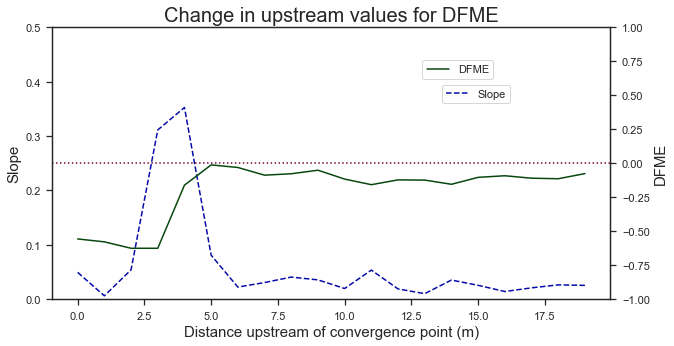

In [53]:
sns.set(style = 'ticks')
fig, ax1 = plt.subplots(figsize = (10, 5))
data = new_drainage_parameters

y1 = "Slope"
y2 = "DFME"

sns.lineplot(data = data,x = "Distance",y = y1, color = 'xkcd:cobalt blue')
ax1.set_ylabel(y1, fontsize=15)
ax1.lines[0].set_linestyle("--")
ax1.set_ylim(0, 0.5)
ax1.set_xlabel('Distance upstream of convergence point (m)', fontsize = 15)
ax1.legend([y1],bbox_to_anchor=(0.3, 0.21, 0.53, 0.6))
ax2 = ax1.twinx()

ax2.set_ylim(-1, 1)
sns.lineplot(data=data,x = "Distance",y=y2,color='xkcd:forest green',ax = ax2)
ax2.set_ylabel(y2, fontsize = 15)
#ax2.lines[0].set_linestyle("--")
ax2.legend([y2],bbox_to_anchor=(0.3, 0.5, 0.5, 0.4))
#plt.axvline(x=17, color = 'xkcd:merlot', linestyle = 'dotted')
#plt.axvline(x=20, color = 'xkcd:merlot', linestyle = 'dotted')
plt.axhline(y=0, color = 'xkcd:merlot', linestyle = 'dotted')
#ax1.text(18, -0.8, r'Gully head', fontsize=15, rotation = 90)
plt.title('Change in upstream values for DFME', fontsize = 20)

# Find edges

In [409]:
def gullyUnknownAngle(lat_dis, lon_dis):
    """Find ... """

    #################################################################################################
    # For gullies perfectly aligned along cardinal dorections. Quadrant is set to zero because they are all on boundaries.
    if lon_dis == 0 and lat_dis < 0:
        exact_angle = 180
        quadrant = 0
        
    elif lon_dis == 0 and lat_dis > 0:
        exact_angle = 0
        quadrant = 0
        
    elif lat_dis == 0 and lon_dis > 0:
        exact_angle = 90
        quadrant = 0
        
    elif lat_dis == 0 and lon_dis < 0:
        exact_angle = 270
        quadrant = 0
    #################################################################################################
    # For gullies of all otehr abgles.
    elif lat_dis > 0 and lon_dis > 0:
        angle_max = 90
        angle_min = 0
        quadrant = 1
        print('Quadrant = Q1', 'min angle', str(angle_min), 'max angle', str(angle_max))
        theta_a = np.degrees(np.arctan(np.abs(lat_dis)/np.abs(lon_dis)))
    
    elif lat_dis > 0 and lon_dis < 0:
        angle_max = 360
        angle_min = 270
        quadrant = 2
        print('Quadrant = Q2', 'min angle', str(angle_min), 'max angle', str(angle_max))
        theta_a = np.degrees(np.arctan(np.abs(lat_dis)/np.abs(lon_dis)))
        
    elif lat_dis < 0 and lon_dis < 0:
        angle_max = 270
        angle_min = 180
        quadrant = 3
        print('Quadrant = Q3', 'min angle', str(angle_min), 'max angle', str(angle_max))
        theta_a = np.degrees(np.arctan(np.abs(lat_dis)/np.abs(lon_dis)))
        
    else:
        angle_max = 180
        angle_min = 90
        quadrant = 4
        print('Quadrant = Q4', 'min angle', str(angle_min), 'max angle', str(angle_max))
        theta_a = np.degrees(np.arctan(np.abs(lat_dis)/np.abs(lon_dis)))   

    if quadrant == 1:
        gully_orientation = angle_max - theta_a
    elif quadrant == 2:
        gully_orientation = angle_min + theta_a
    elif quadrant == 3:
        gully_orientation = angle_max - theta_a
    elif quadrant == 4:
        gully_orientation = angle_min + theta_a
    else:
        gully_orientation = exact_angle
        
    return gully_orientation
class GullyOrientation:
    """Convention for first direction to take (d1) in cross section method 
    follows directional convention used in Landlab."""
    possible_angles = np.array([90, 0, 270, 180, 45, 315, 225, 135, 360])
    def __init__(self, angle, outlet, grid_shape):
        self.angle = angle
        self.outlet = outlet
        self.grid_shape = grid_shape
        idx = (np.abs(self.possible_angles - self.angle)).argmin() 
        find_angle_from_list = self.possible_angles[idx]
        self.closest_angle = find_angle_from_list

    def cross_section(self, line_length):
        cross_section_nodes_d1 = [self.outlet]
        cross_section_nodes_d2 = [self.outlet]
        if self.closest_angle == 90 or self.closest_angle == 270:
            print('east-west gully')
            for i in range(0, line_length):
                current_node_d1 = cross_section_nodes_d1[i]             
                current_node_d2 = cross_section_nodes_d2[i]
                next_node_d1 = current_node_d1 - self.grid_shape[1]
                next_node_d2 = current_node_d2 + self.grid_shape[1]
                cross_section_nodes_d1.append(next_node_d1)
                cross_section_nodes_d2.append(next_node_d2)

        elif self.closest_angle == 0 or self.closest_angle == 180 or self.closest_angle == 360:
            print('north-south gully')
            for i in range(0, line_length):
                current_node_d1 = cross_section_nodes_d1[i]
                current_node_d2 = cross_section_nodes_d2[i]
                next_node_d1 = current_node_d1 + 1
                next_node_d2 = current_node_d2 - 1
                cross_section_nodes_d1.append(next_node_d1)
                cross_section_nodes_d2.append(next_node_d2)

        elif self.closest_angle == 45 or self.closest_angle == 225:
            print('northeast-southwest gully')
            for i in range(0, line_length):
                current_node_d1 = cross_section_nodes_d1[i]             
                current_node_d2 = cross_section_nodes_d2[i]
                next_node_d1 = current_node_d1 - (self.grid_shape[1] + 1)
                next_node_d2 = current_node_d2 + (self.grid_shape[1] + 1)
                cross_section_nodes_d1.append(next_node_d1)
                cross_section_nodes_d2.append(next_node_d2)
        else:
            print('northwest-southeast gully')
            for i in range(0, line_length):
                current_node_d1 = cross_section_nodes_d1[i]             
                current_node_d2 = cross_section_nodes_d2[i]
                next_node_d1 = current_node_d1 - (self.grid_shape[1] - 1)
                next_node_d2 = current_node_d2 + (self.grid_shape[1] - 1)
                cross_section_nodes_d1.append(next_node_d1)
                cross_section_nodes_d2.append(next_node_d2)

        cross_section_nodes = np.array(list(set(cross_section_nodes_d1 + cross_section_nodes_d2)))
        return cross_section_nodes

In [410]:
def assignDirection(cross_section_df, approximate_angle):

    d1 = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']<=0, 'DFME'].values.tolist()
    d1.reverse() # Reversed because starts from end for left side only.
    d1_nodes = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']<=0, 'Node'].values.tolist()
    d1_nodes.reverse()
    d2 = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']>=0, 'DFME'].values.tolist()
    d2_nodes = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']>=0, 'Node'].values.tolist()
   
    return d1, d1_nodes, d2, d2_nodes
def assignDirectionElev(cross_section_df, approximate_angle):

    d1 = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']<=0, 'Elevation'].values.tolist()
    d1.reverse() # Reversed because starts from end for left side only.
    d1_nodes = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']<=0, 'Node'].values.tolist()
    d1_nodes.reverse()
    d2 = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']>=0, 'Elevation'].values.tolist()
    d2_nodes = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']>=0, 'Node'].values.tolist()
   
    return d1, d1_nodes, d2, d2_nodes
def pointsAlongGully(node_at_gully_edge, gully_angle_to_follow, distance, grid_node_array):
    
    """Can do both left and right sides."""

    if gully_angle_to_follow == 0 or gully_angle_to_follow == 360:
        print('north_to_south gully')
        node_next_to_head = node_at_gully_edge - (5 * grid_node_array.shape[1])

    elif gully_angle_to_follow == 180:
        print('south_to_north gully')
        node_next_to_head = node_at_gully_edge + (5 * grid_node_array.shape[1])

    elif gully_angle_to_follow == 270:
        print('west_to_east gully')
        node_next_to_head = node_at_gully_edge - 5
        
    elif gully_angle_to_follow == 90:
        print('east_to_west gully')
        node_next_to_head = node_at_gully_edge + 5
        
    elif gully_angle_to_follow == 45:
        print('northeast_to_southwest gully')
        node_next_to_head = node_at_gully_edge - (5 * grid_node_array.shape[1] - 1)
        
    elif gully_angle_to_follow == 225:
        print('southwest_to_notheast gully')
        node_next_to_head = node_at_gully_edge + (5 * grid_node_array.shape[1] - 1)
        
    elif gully_angle_to_follow == 315:
        print('northwest_to_southeast gully')
        node_next_to_head = node_at_gully_edge - (5 * grid_node_array.shape[1] + 1)
        
    else:
        print('southeast_to_northwest gully')
        node_next_to_head = node_at_gully_edge + (5 * grid_node_array.shape[1] + 1)

    return node_next_to_head

In [411]:
test_gully_head = {270132: 276558}

In [412]:
start_time = timeit.default_timer()

line_length = 20
list_of_final_gully_heads = []
gully_edges_dict = {}
for key, value in test_gully_head.items():
    cp = key
    print('cp: ',cp)
    gh = value
    print('gh: ', gh)
    gh_lat = np.where(grid_nodes == gh)[0][0]
    cp_lat = np.where(grid_nodes == cp)[0][0]
    gh_lon = np.where(grid_nodes == gh)[1][0]
    cp_lon = np.where(grid_nodes == cp)[1][0]

    lat_displacement = cp_lat - gh_lat
    print('lat: ', lat_displacement)
    lon_displacement = gh_lon - cp_lon
    print('lon: ', lon_displacement)

    # a^2 + b^2 = c^2
    gully_length = np.sqrt(lat_displacement**2 + lon_displacement**2)
    
    gully_angle = gullyUnknownAngle(lat_displacement, lon_displacement)   
    
    gully_and_cross_section = GullyOrientation(gully_angle, key, mg.shape)
    
    approx_angle = gully_and_cross_section.closest_angle
        
    cross_section_nodes = gully_and_cross_section.cross_section(line_length)
    
    result = np.where(grid_nodes == key)
    #################################################################################################
    # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
    row_index = result[0][0];
    col_index = result[1][0];
    #################################################################################################
    # Create a subset based on above. Plus 1 to bottom abnd right so that the currenmmt gully ead node is always the 
    # central grid node of the subset.
    subset_row_top = int(row_index - line_length)
    subset_row_bot = int(row_index + line_length) + 1
    subset_col_left = int(col_index - line_length)
    subset_col_right = int(col_index + line_length) + 1
    #################################################################################################
    # Restrict the size of the subset in cases where it is on the edge of a DEM.
    subset_row_top_adjusted = max(subset_row_top, 0);
    subset_row_bot_adjusted = min(subset_row_bot, input_DEM.shape[0]);
    subset_col_left_adjusted = max(subset_col_left, 0);
    subset_col_right_adjusted = min(subset_col_right, input_DEM.shape[1]);
    #################################################################################################
    # Find the offset required by restricting the size of the subset around DEM edges.
    # This offset is needed to find the new location of the current gully head grid cell (no longer center of the subset).
    offset_row_top = int(np.sqrt((subset_row_top - subset_row_top_adjusted)**2)) * -1;
    offset_row_bot = int(np.sqrt((subset_row_bot - subset_row_bot_adjusted)**2));
    offset_col_left = int(np.sqrt((subset_col_left - subset_col_left_adjusted)**2)) * -1;
    offset_col_right = int(np.sqrt((subset_col_right - subset_col_right_adjusted)**2));
    #################################################################################################
    # Create subset around the current gully head grid node. 
    grid_nodes_subset_copy = np.copy(grid_nodes).astype('int32');
    grid_nodes_subset = grid_nodes_subset_copy[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                 subset_col_left_adjusted:subset_col_right_adjusted]

    lat = grid_nodes_subset.shape[0]
    lon = grid_nodes_subset.shape[1]

    nodes_1d = np.squeeze(grid_nodes_subset.reshape(1, lat * lon))

    cross_section_subset_mask = np.isin(nodes_1d,cross_section_nodes).reshape(grid_nodes_subset.shape)
    cross_section_subset_image = cross_section_subset_mask.astype('uint8')

    #################################################################################################
    # Take subsets of desired surface parameters for gulyl analysis (e.g. DFME, slope, curvature etc)
    #################################################################################################
    elevation_subset_copy = np.copy(input_DEM).astype('float32');
    cross_section_elevation = elevation_subset_copy[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                 subset_col_left_adjusted:subset_col_right_adjusted]

    cross_section_elevation[~cross_section_subset_mask] = np.nan
    cross_section_elevation_1d = np.squeeze(cross_section_elevation.reshape(1, lat * lon))
    #################################################################################################
    dfme_subset_copy = np.copy(DFME).astype('float32');
    cross_section_dfme = dfme_subset_copy[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                 subset_col_left_adjusted:subset_col_right_adjusted]

    cross_section_dfme[~cross_section_subset_mask] = np.nan
    cross_section_dfme_1d = np.squeeze(cross_section_dfme.reshape(1, lat * lon))
    #################################################################################################
    
    node_cross_section_dfme_dict = {}
    for A, B in zip(nodes_1d, cross_section_dfme_1d):
        node_cross_section_dfme_dict[A] = B
    
    node_cross_section_elevation_dict = {}
    for A, B in zip(nodes_1d, cross_section_elevation_1d):
        node_cross_section_elevation_dict[A] = B
        
    dfme_cross_section_unordered = { key:value for key, 
                                     value in node_cross_section_dfme_dict.items() if ~np.isnan(value) }

    elevation_cross_section_unordered = { key:value for key, 
                                         value in node_cross_section_elevation_dict.items() if ~np.isnan(value) }

    ds = [dfme_cross_section_unordered, elevation_cross_section_unordered]
    d = {}
    for k in dfme_cross_section_unordered.keys():
        d[k] = tuple(d[k] for d in ds)

    cross_section_parameters = pd.DataFrame.from_dict(d)

    cross_section_parameters.rename(index={0:'DFME', 1:'Elevation'}, inplace=True)

    cross_section_parameters_transpose = cross_section_parameters.T

    cross_section_parameters_transpose.insert(0, "Distance", 0)
    
    for j in range(0, (line_length * 2)+1):
        if j < line_length:
            cross_section_parameters_transpose.iloc[j,0] = -line_length + j
        else:
            cross_section_parameters_transpose.iloc[j,0] = j - line_length
        
    cross_section_parameters_transpose['Node'] = cross_section_parameters_transpose.index.values
    
    dir1, dir1_nodes, dir2, dir2_nodes = assignDirection(cross_section_parameters_transpose, 
                                                 gully_and_cross_section.closest_angle)
    
    dir1e, dir1_nodes, dir2e, dir2_nodes = assignDirectionElev(cross_section_parameters_transpose, 
                                         gully_and_cross_section.closest_angle)


    #outcome_d1, D1 = checkGullyEdges(dir1,3,3,-0.2,-0.2)
    #outcome_d2, D2 = checkGullyEdges(dir2,3,3,-0.2,-0.2)
    
    outcome_d1, D1 = checkGullyEdgesElev(dir1,dir1e, step_s,comp_d,-0.2,-0.1, 0.3)
    outcome_d2, D2 = checkGullyEdgesElev(dir2, dir2e, step_s,comp_d,-0.2,-0.1, 0.3)
    print('O1: ', outcome_d1)
    print('O2: ', outcome_d2)
    
    if outcome_d1 == 'yes' and outcome_d2 == 'yes':
        list_of_final_gully_heads.append(key)
        # Directions will depend on orientation so need two sets of schemes.
        if approx_angle == 180 or approx_angle == 225 or approx_angle == 270 or approx_angle == 315:
            
            points_next_to_head_d1 = pointsAlongGully(dir1_nodes[D1], approx_angle, 5, grid_nodes)
            points_next_to_head_d2 = pointsAlongGully(dir2_nodes[D2], approx_angle, 5, grid_nodes)
            
            print('d1 : ', dir1_nodes[D1], 'd2: ', dir2_nodes[D2], 'New points: ', 
                  points_next_to_head_d1, points_next_to_head_d2, 'angle: ', approx_angle)
            
            gully_edges_dict[key] = [dir1_nodes[D1], dir2_nodes[D2], points_next_to_head_d1, points_next_to_head_d2]
            
        else:           
            points_next_to_head_d1 = pointsAlongGully(dir1_nodes[D1], approx_angle, 5, grid_nodes)
            points_next_to_head_d2 = pointsAlongGully(dir2_nodes[D2], approx_angle, 5, grid_nodes)
            
            print('d1 : ', dir1_nodes[D1], 'd2: ', dir2_nodes[D2], 'New points: ', 
                  points_next_to_head_d1, points_next_to_head_d2, 'angle: ', approx_angle)
            
            gully_edges_dict[key] = [dir2_nodes[D2],dir1_nodes[D1], points_next_to_head_d2, points_next_to_head_d1]
        
    else:
        print('no')

timeit.default_timer() - start_time


cp:  270132
gh:  276558
lat:  -6
lon:  6
Quadrant = Q4 min angle 90 max angle 180
northwest-southeast gully
upstream mean:  142.624994914
downstream min:  142.348999023
elevation difference:  0.275995890299
upstream mean:  142.613998413
downstream min:  142.266998291
elevation difference:  0.34700012207
upstream mean:  144.894002279
downstream min:  142.529998779
elevation difference:  2.36400349935
upstream mean:  145.101003011
downstream min:  142.865997314
elevation difference:  2.23500569661
upstream mean:  145.293665568
downstream min:  143.378997803
elevation difference:  1.9146677653
upstream mean:  145.526331584
downstream min:  143.714996338
elevation difference:  1.81133524577
upstream mean:  145.748662313
downstream min:  144.070007324
elevation difference:  1.67865498861
upstream mean:  145.974995931
downstream min:  144.421005249
elevation difference:  1.55399068197
upstream mean:  146.208994548
downstream min:  144.652999878
elevation difference:  1.5559946696
upstream me

0.0980790000030538

In [413]:
cross_section_parameters_transpose

,Distance,DFME,Elevation,Node
248752,-20,0.262654,141.052002,248752
249821,-19,0.296305,141.296997,249821
250890,-18,0.421373,141.636002,250890
251959,-17,0.406973,141.832001,251959
253028,-16,0.169170,141.785004,253028
254097,-15,0.315724,142.102997,254097
255166,-14,0.262922,142.199005,255166
256235,-13,0.023057,142.087006,256235
257304,-12,0.039299,142.210007,257304
258373,-11,0.474751,142.729004,258373


In [414]:
gully_angle

135.0

In [415]:
gully_edges_df = pd.DataFrame.from_dict(gully_edges_dict).T

Text(0.5, 1.0, 'Change in upstream values for DFME')

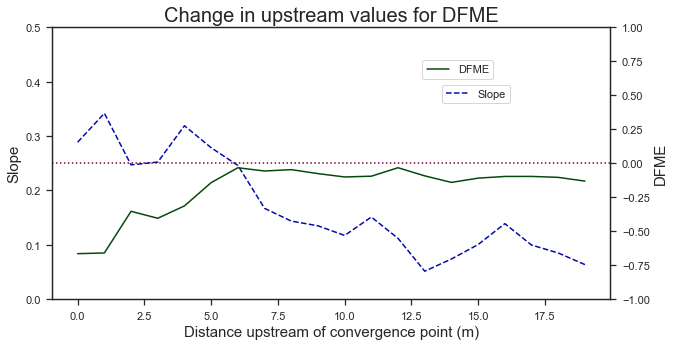

In [416]:
sns.set(style = 'ticks')
fig, ax1 = plt.subplots(figsize = (10, 5))
data = new_drainage_parameters

y1 = "Slope"
y2 = "DFME"

sns.lineplot(data = data,x = "Distance",y = y1, color = 'xkcd:cobalt blue')
ax1.set_ylabel(y1, fontsize=15)
ax1.lines[0].set_linestyle("--")
ax1.set_ylim(0, 0.5)
ax1.set_xlabel('Distance upstream of convergence point (m)', fontsize = 15)
ax1.legend([y1],bbox_to_anchor=(0.3, 0.21, 0.53, 0.6))
ax2 = ax1.twinx()

ax2.set_ylim(-1, 1)
sns.lineplot(data=data,x = "Distance",y=y2,color='xkcd:forest green',ax = ax2)
ax2.set_ylabel(y2, fontsize = 15)
#ax2.lines[0].set_linestyle("--")
ax2.legend([y2],bbox_to_anchor=(0.3, 0.5, 0.5, 0.4))
#plt.axvline(x=17, color = 'xkcd:merlot', linestyle = 'dotted')
#plt.axvline(x=20, color = 'xkcd:merlot', linestyle = 'dotted')
plt.axhline(y=0, color = 'xkcd:merlot', linestyle = 'dotted')
#ax1.text(18, -0.8, r'Gully head', fontsize=15, rotation = 90)
plt.title('Change in upstream values for DFME', fontsize = 20)

In [417]:
gully_edges_df

""


In [394]:
gully_edges_df.columns = ['LeftCP', 'RightCP', 'LeftGH', 'RightGH']

In [395]:
left_edge_points = gully_edges_df['LeftCP'].values
right_edge_points = gully_edges_df['RightCP'].values
left_head_points = gully_edges_df['LeftGH'].values
right_head_points = gully_edges_df['RightGH'].values

In [396]:
gully_left_edges = np.isin(grid_nodes,left_edge_points).astype('uint8')
gully_right_edges = np.isin(grid_nodes,right_edge_points).astype('uint8')
gully_left_head = np.isin(grid_nodes,left_head_points).astype('uint8')
gully_right_head = np.isin(grid_nodes,right_head_points).astype('uint8')

In [397]:
cross_section_parameters_transpose

,Distance,DFME,Elevation,Node
248752,-20,0.262654,141.052002,248752
249821,-19,0.296305,141.296997,249821
250890,-18,0.421373,141.636002,250890
251959,-17,0.406973,141.832001,251959
253028,-16,0.169170,141.785004,253028
254097,-15,0.315724,142.102997,254097
255166,-14,0.262922,142.199005,255166
256235,-13,0.023057,142.087006,256235
257304,-12,0.039299,142.210007,257304
258373,-11,0.474751,142.729004,258373


Text(0.5, 1.0, 'Gully cross section DFME and slope')

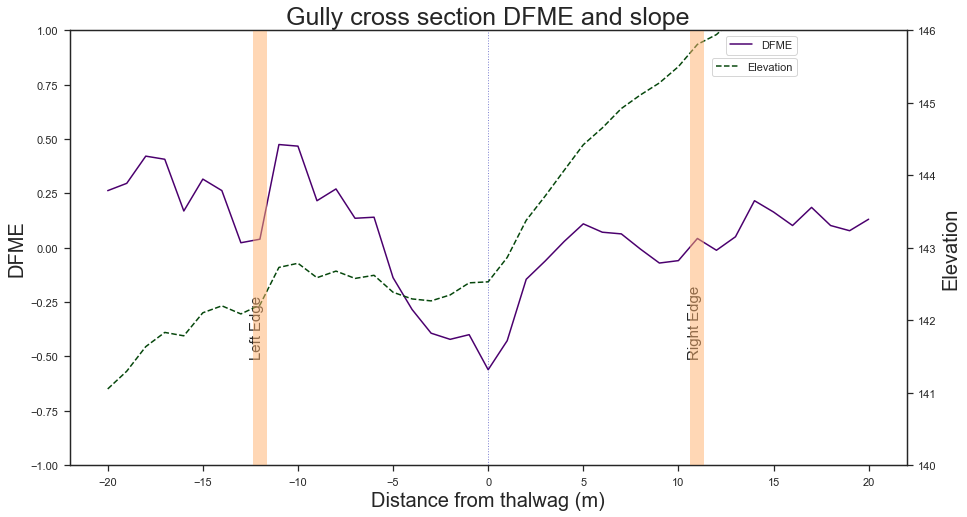

In [401]:
sns.set(style = 'ticks')
fig, ax1 = plt.subplots(figsize = (15, 8))
x_value = "Distance"
y1_value = "DFME"
y2_value = "Elevation"
sns.lineplot(data = cross_section_parameters_transpose, x = x_value, y = y1_value, 
             color = 'xkcd:royal purple')
ax1.set_ylabel(y1_value, fontsize=20)
#ax1.annotate('Thalweg', arrowprops = dict(facecolor = 'black'), xy = (0, -23), xytext = (1, -29))
#ax1.lines[0].set_linestyle("--")
ax1.set_ylim(-1, 1)
ax1.set_xlabel('Distance from thalwag (m)', fontsize = 20)
ax1.legend([y1_value],bbox_to_anchor=(0.375, 0.6, 0.5, 0.4))
ax2 = ax1.twinx()
ax2.set_ylim(140, 146)
sns.lineplot(data = cross_section_parameters_transpose, x = x_value, y = y2_value
             , color = 'xkcd:forest green', ax = ax2)
ax2.lines[0].set_linestyle("--")
#ax2.set_ylabel(y2_value, fontsize = 15)
ax2.set_ylabel(y2_value, fontsize = 20)
ax2.legend([y2_value],bbox_to_anchor=(0.375, 0.55, 0.5, 0.4))
plt.axvline(x=11, color = 'xkcd:apricot', linewidth = 14, alpha = 0.5)
plt.axvline(x=-12, color = 'xkcd:apricot', linewidth = 14, alpha = 0.5)
plt.axvline(x=0, color = 'xkcd:cobalt blue', linewidth = 1, alpha = 0.5, linestyle = 'dotted')
plt.axhline(y=0, color = 'xkcd:cobalt blue', linewidth = 1, alpha = 0.5, linestyle = 'dotted')
#plt.axvline(x=0, color = 'xkcd:cobalt blue', alpha = 0.5, linestyle = 'dotted')
#plt.axvline(x=11, color = 'xkcd:pumpkin', linestyle = 'dotted')
ax1.text(-12.5, -0.5, r'Left Edge', fontsize=15, rotation = 90)
ax1.text(10.5, -0.5, r'Right Edge', fontsize=15, rotation = 90)
plt.title('Gully cross section DFME and slope', fontsize = 25)

In [118]:
cross_section_grid = np.isin(grid_nodes,cross_section_parameters_transpose['Node'].values).astype('uint8')

In [ ]:
len(list_of_final_gully_heads)

In [ ]:
all_final_gully_head_nodes = np.isin(grid_nodes,list_of_final_gully_heads).astype('uint8')

In [45]:
def np_array_to_Geotiff(newfile, original_tiff, np_array, dtype):
    
    cols = np_array.shape[1]
    rows = np_array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = original_tiff.GetGeoTransform() 
    driver = gdal.GetDriverByName('GTiff')
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Float64": 
        GDT_dtype = gdal.GDT_Float64
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")
    
    if np_array.ndim == 2:
        band_num = 1
    else:
        band_num = np_array.shape[2]

    outRaster = driver.Create(newfile, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    
    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
    
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(np_array)
        else:
            outband.WriteArray(np_array[:,:,b])

    # setteing srs from input tif file.
    prj=original_tiff.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    outRaster = None
    
    return outRaster

In [54]:
np_array_to_Geotiff('pw.tif', input_geotiff, preliminary_width, drainage_area.dtype)

C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  
